In [1]:
# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define your Architecture here
import tensorflow as tf
from tensorflow.contrib.layers import flatten

class my_LeNet:
    def __init__(self, d, n, mu = 0, sigma = 0.1, lr = 0.001):
        self.mu = mu
        self.sigma = sigma
        self.n = n
        self.x = tf.placeholder(tf.float32, (None, d, d, 1))  # place holder for input image dimension 28 x 28
        self.y = tf.placeholder(tf.int32, (None,n))
        self.keep_prob = tf.placeholder(tf.float32) # probability to keep units
        
        
        self.logits = self.model(self.x)
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=self.logits)
        self.loss = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr)
        self.train = optimizer.minimize(self.loss)
        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        self.saver = tf.train.Saver()
   
        
        
    def model(self,x):   
        # Build Architecture
        keep_prob = 0.7
        # Layer 1: Convolutional. Filter 5x5 num_filters = 6 Input_depth =1
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = self.mu, stddev = self.sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        
        # Max Pool 1 
        self.conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        
        # Layer 2: Convolutional. Filter 5x5 num_filters = 16  Input_depth =6
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = self.mu, stddev = self.sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(self.conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)

        # Max Pool 2.
        self.conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Flatten. 
        fc0   = flatten(self.conv2)
        print("x shape:",fc0.get_shape())
        
        # Layer 3: Fully Connected. Input = fc0.get_shape[-1]. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 120), mean = self.mu, stddev = self.sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        fc1    = tf.nn.relu(fc1)
        
        # Dropout
        x = tf.nn.dropout(fc1, keep_prob)

        # Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(x, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)
        
        # Dropout
        x = tf.nn.dropout(fc2, keep_prob)

        # Layer 6: Fully Connected. Input = 120. Output = n_classes.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, self.n), mean = self.mu, stddev = self.sigma))
        fc3_b  = tf.Variable(tf.zeros(self.n))
        logits = tf.matmul(x, fc3_W) + fc3_b
        #logits = tf.nn.softmax(logits)
        return logits
        
    def fit(self,X,Y,X_val,Y_val,epochs=10, batch_size=100):
        X_train, y_train = X, Y
        num_examples = len(X_train)
        l = []
        val_l = []
        max_val = 0
        for i in range(epochs):
            total = 0
            for offset in range(0, num_examples, batch_size):  # Learn Batch wise
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                _, loss = self.sess.run([self.train,self.loss], feed_dict={self.x: batch_x, self.y: batch_y})
                total += loss
            l.append(total/num_examples)
            accuracy_val = self.sess.run(self.accuracy, feed_dict={self.x: X_val, self.y: Y_val})
            accuracy = self.sess.run(self.accuracy, feed_dict={self.x: X, self.y: Y})
            loss_val = self.sess.run(self.loss, feed_dict={self.x:X_val,self.y:Y_val})
            val_l.append(loss_val)
            print("EPOCH {}/{} loss is {:.3f} training_accuracy {:.3f} and validation accuracy is {:.3f}".\
                  format(i+1,epochs,total/num_examples, accuracy, accuracy_val))
            if accuracy_val > max_val:
                save_path = self.saver.save(self.sess, "/tmp/lenet1.ckpt")
                print("Model saved in path: %s" % save_path)
                max_val = accuracy_val

        self.saver.restore(self.sess, "/tmp/lenet1.ckpt")
        print("Restored model with highest validation accuracy")
        accuracy_val = self.sess.run(self.accuracy, feed_dict={self.x: X_val, self.y: Y_val})
        accuracy = self.sess.run(self.accuracy, feed_dict={self.x: X, self.y: Y})
        return l,val_l, accuracy, accuracy_val 
    
    def predict(self, X):
        return self.sess.run(self.logits,feed_dict={self.x:X})


/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def load_data():
    # Read the data and create train, validation and test dataset
    data = pd.read_csv('train.csv')
    train = data.sample(frac=0.8, random_state=255)   # This ensures always 80% of data is training and rest Validation  unlike using np.random
    val = data.drop(train.index)
    test = pd.read_csv('test.csv')
    return train, val, test
    
def create_data(df):
    labels = df.loc[:]['label']
    y_one_hot = pd.get_dummies(labels).astype(np.uint8)
    y = y_one_hot.values # One Hot encode the labels
    x = df.iloc[:,1:].values
    x = x.astype(np.float)
    # Normalize data
    x = np.multiply(x, 1.0 / 255.0)
    x = x.reshape(-1, 28, 28, 1) # return each images as 96 x 96 x 1
    return x,y

train, val, test = load_data()
X_train, y_train = create_data(train)
X_val, y_val = create_data(val)
X_test = (test.iloc[:,:].values).astype(np.float)
X_test = np.multiply(X_test, 1.0 / 255.0)
X_test = X_test.reshape(-1, 28, 28, 1) # return each images as 96 x 96 x 1

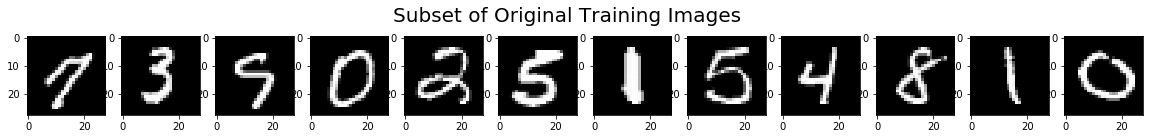

In [4]:
# take subset of training data
x_train_subset = X_train[:12]


# visualize subset of training data
fig = plt.figure(figsize=(20,2))
for i in range(0, len(x_train_subset)):
    ax = fig.add_subplot(1, 12, i+1)
    ax.imshow(x_train_subset[i].reshape(28,28), cmap='gray')
fig.suptitle('Subset of Original Training Images', fontsize=20)
plt.show()

In [5]:
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_val)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an handwritten digits?
image_shape = X_train.shape[1:-1]

# How many unique classes/labels there are in the dataset.
n_classes = y_train.shape[-1]

print("Number of training examples =", n_train)
print("Number of Validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 33600
Number of Validation examples = 8400
Number of testing examples = 28000
Image data shape = (28, 28)
Number of classes = 10


In [6]:
# Define the data values
d = image_shape[0]
n = n_classes
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train)

In [7]:
# Create the Model
my_model = my_LeNet(d, n)

x shape: (?, 256)


In [8]:
### Train model  here.
loss, val_loss, train_acc, val_acc = my_model.fit(X_train, y_train, X_val, y_val, epochs=50) 

EPOCH 1/50 loss is 0.006 training_accuracy 0.926 and validation accuracy is 0.929
Model saved in path: /tmp/lenet1.ckpt
EPOCH 2/50 loss is 0.002 training_accuracy 0.953 and validation accuracy is 0.954
Model saved in path: /tmp/lenet1.ckpt
EPOCH 3/50 loss is 0.001 training_accuracy 0.965 and validation accuracy is 0.962
Model saved in path: /tmp/lenet1.ckpt
EPOCH 4/50 loss is 0.001 training_accuracy 0.971 and validation accuracy is 0.969
Model saved in path: /tmp/lenet1.ckpt
EPOCH 5/50 loss is 0.001 training_accuracy 0.976 and validation accuracy is 0.972
Model saved in path: /tmp/lenet1.ckpt
EPOCH 6/50 loss is 0.001 training_accuracy 0.977 and validation accuracy is 0.975
Model saved in path: /tmp/lenet1.ckpt
EPOCH 7/50 loss is 0.001 training_accuracy 0.981 and validation accuracy is 0.977
Model saved in path: /tmp/lenet1.ckpt
EPOCH 8/50 loss is 0.001 training_accuracy 0.983 and validation accuracy is 0.978
Model saved in path: /tmp/lenet1.ckpt
EPOCH 9/50 loss is 0.001 training_accura

Text(0,0.5,'Loss')

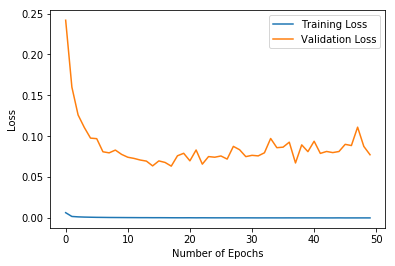

In [9]:
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")

In [10]:
### Calculate and report the accuracy on the training and validation set.
print("Accuracy on training dataset is {:.3f}% and on Validation dataset is {:.3f}%".
     format(train_acc*100,val_acc*100))

Accuracy on training dataset is 99.658% and on Validation dataset is 98.607%
